In [1]:
# Run in terminal or command prompt
# python3 -m spacy download en
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
from unidecode import unidecode
from nltk.corpus import stopwords
%matplotlib inline

In [2]:
#Carregando base de dados
df = pd.read_csv('database.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop_duplicates(subset='NM_PROJETO', inplace=True)
df

,ID_PROJETO,NM_PROJETO,NM_AREA_CONCENTRACAO,NM_LINHA_PESQUISA
0,501790.0,ATIVIDADES INVESTIGATIVAS NO ENSINO DE CIÊNCIAS,ENSINO DE CIÊNCIAS E MATEMÁTICA,"EPISTEMOLOGIA, DIDÁTICA E CURRÍCULO NO ENSINO ..."
1,455955.0,ENSINO DE CIÊNCIAS NOS ANOS INICIAIS DO ENSINO...,ENSINO DE CIÊNCIAS E MATEMÁTICA,FORMAÇÃO DE PROFESSORES DE CIÊNCIAS E MATEMÁTICA
2,433113.0,A HISTÓRIA DA MATEMÁTICA NOS EVENTOS NACIONAIS...,EDUCAÇÃO MATEMÁTICA,"HISTÓRIA, FILOSOFIA E SOCIOLOGIA DAS CIÊNCIAS ..."
3,391160.0,ACOLHIMENTO NO SUS: PERCEPÇÕES DO ASSISTENTE S...,FORMAÇÃO INTERDISCIPLINAR EM SAÚDE,FORMAÇÃO EM SAÚDE
4,248091.0,"INVESTIGAÇÃO, CONSTRUÇÃO E ANÁLISE DE PROCESSO...",PROCESSOS E PRODUTOS PARA O ENSINO TECNOLÓGICO,RECURSOS PARA O ENSINO TÉCNICO E TECNOLÓGICO
...,...,...,...,...
480122,484452.0,"PETROLOGIA, TECTÔNICA E MORFOESTRUTURAS DE REL...",MANEJO E CONSERVAÇÃO DE BACIAS HIDROGRÁFICAS,MANEJO E DINÂMICA DE RECURSOS NATURAIS
480197,163744.0,FERNANDO PESSOA: AUTORIA E IRONIA,LITERATURA PORTUGUESA,POÉTICAS DE EXPRESSÃO PORTUGUESA
480251,514793.0,CURSO DE EDUCAÇÃO DO CAMPO,"CIÊNCIA, TECNOLOGIA E SOCIEDADE - CTS","SOCIEDADE, AMBIENTE E EDUCAÇÃO"
480295,423066.0,ASPECTOS TEÓRICOS DOS CURSOS DE GRADUAÇÃO EM F...,EDUCAÇÃO EM CIÊNCIAS E MATEMÁTICA,CURRÍCULO E FORMAÇÃO DE PROFESSORES PARA O ENS...


In [3]:
#Primeiro preprocessamento dos documentos

data = df.NM_PROJETO.values.tolist()
# Remove new line characters
data = [re.sub(r'\s+', ' ', text) for text in data]
# Remove distracting single quotes
data = [re.sub(r"\'", "", text) for text in data]
# Remove accents
data = [unidecode(text) for text in data]
data[:5]

['ATIVIDADES INVESTIGATIVAS NO ENSINO DE CIENCIAS',
 'ENSINO DE CIENCIAS NOS ANOS INICIAIS DO ENSINO FUNDAMENTAL: REALIDADE E PERSPECTIVAS',
 'A HISTORIA DA MATEMATICA NOS EVENTOS NACIONAIS DE EDUCACAO MATEMATICA: PRIMEIRA DECADA DO SECULO XXI',
 'ACOLHIMENTO NO SUS: PERCEPCOES DO ASSISTENTE SOCIAL SOBRE SUA PRATICA PROFISSIONAL',
 'INVESTIGACAO, CONSTRUCAO E ANALISE DE PROCESSOS DE ENSINO E APRENDIZAGEM AUXILIADOS POR RECURSOS TECNOLOGICOS']

In [4]:
#Documentos transformados em palavras
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [5]:
#dicionario de palavras
def make_dict(data):
    text_out = []
    for text in data:
        doc = " ".join(text)
        text_out.append(doc)
    return text_out

In [6]:
#separando em palavras
data_words = list(sent_to_words(data))
print(data_words[:5])

[['atividades', 'investigativas', 'no', 'ensino', 'de', 'ciencias'], ['ensino', 'de', 'ciencias', 'nos', 'anos', 'iniciais', 'do', 'ensino', 'fundamental', 'realidade', 'perspectivas'], ['historia', 'da', 'matematica', 'nos', 'eventos', 'nacionais', 'de', 'educacao', 'matematica', 'primeira', 'decada', 'do', 'seculo', 'xxi'], ['acolhimento', 'no', 'sus', 'percepcoes', 'do', 'assistente', 'social', 'sobre', 'sua', 'pratica', 'profissional'], ['investigacao', 'construcao', 'analise', 'de', 'processos', 'de', 'ensino', 'aprendizagem', 'auxiliados', 'por', 'recursos', 'tecnologicos']]


In [7]:
mydict = make_dict(data_words)
mydict[:5]

['atividades investigativas no ensino de ciencias',
 'ensino de ciencias nos anos iniciais do ensino fundamental realidade perspectivas',
 'historia da matematica nos eventos nacionais de educacao matematica primeira decada do seculo xxi',
 'acolhimento no sus percepcoes do assistente social sobre sua pratica profissional',
 'investigacao construcao analise de processos de ensino aprendizagem auxiliados por recursos tecnologicos']

In [9]:
#setting stopwords
#new_stopwords foram selecionadas a partir dos testes
#em geral são nomes de estados, palavras em outras linguas e palavras que dizem apenas o tipo da pesquisa
new_stopwords = ['são', 'paulo', 'rio', 'janeiro', 'utiliza', 'utilizando', 'utilizar', 'utilização', 
                'sobre', 'and', 'partir', 'america', 'the', 'sob', 'sul', 'norte', 'nordeste', 'estudo', 'mato',
                'grosso', 'minas', 'gerais', 'bahia', 'pernambuco', 'espírito', 'santo', 'grande', 'alagoas', 
                'paraíba']
stpwords = stopwords.words('portuguese') + new_stopwords

stpwords = [unidecode(stpword) for stpword in stpwords]
stpwords = list(set(stpwords))

In [10]:
#ngram_range=(2,2) -> só bigram na matriz esparsa
vect = CountVectorizer(analyzer='word', min_df=10, stop_words=stpwords, ngram_range=(2,2),
                             lowercase=True, token_pattern='[a-zA-Z0-9]{3,}')


bag_of_words = vect.fit_transform(mydict)

In [11]:
#TF IDF
tfidf = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf.fit(bag_of_words)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [12]:
bag_of_wordsTFIDF = tfidf.transform(bag_of_words)

In [13]:
#Modelo
lda_model = LatentDirichletAllocation(n_components=10, learning_decay = 0.9, 
                                      max_iter = 10, learning_method='online', random_state=0)
lda = lda_model.fit_transform(bag_of_wordsTFIDF)
print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.9,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [14]:
#Scores
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(bag_of_words))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(bag_of_words))
# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -825430.3076324408
Perplexity:  4010.6123295695697
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.9,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [15]:
#vendo topicos para analise
def show_topics(vectorizer=vect, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vect, lda_model=lda_model, n_words=15)
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,qualidade vida,promocao saude,sintese caracterizacao,cana acucar,mata atlantica,seculo xxi,doencas cronicas,recursos hidricos,caracterizacao molecular,escolas publicas,frangos corte,saude publica,desenvolvimento produtos,informacao comunicacao,tecnologias informacao
Topic 1,educacao basica,melhoramento genetico,patrimonio cultural,exercicio fisico,direitos fundamentais,redes sociais,ensino historia,novas tecnologias,desenvolvimento sistemas,estado parana,modelagem matematica,desenvolvimento metodos,doencas infecciosas,tomada decisao,sala aula
Topic 2,produtos naturais,formacao docente,seculo xix,ensino fundamental,bacia hidrografica,nucleo estudos,ensino pesquisa,controle biologico,oleos essenciais,latino americana,atividade biologica,pos colheita,profissionais saude,sindrome metabolica,avaliacao propriedades
Topic 3,politicas publicas,formacao professores,ensino aprendizagem,ensino superior,lingua portuguesa,bem estar,avaliacao atividade,servicos saude,praticas educativas,area saude,tratamento efluentes,processo ensino,educacao campo,tempo real,semi arido
Topic 4,ciencia tecnologia,ensino medio,fatores associados,celulas tronco,residuos solidos,especies vegetais,resposta imune,sistema nervoso,educacao matematica,portugues brasileiro,grupo pesquisa,praticas pedagogicas,sensoriamento remoto,nacional ciencia,distrito federal
Topic 5,meio ambiente,criancas adolescentes,saude mental,atividade fisica,sistemas producao,plantas medicinais,educacao superior,movimentos sociais,atencao basica,avaliacao efeito,avaliacao clinica,marcadores moleculares,doenca chagas,direito internacional,desenvolvimento validacao
Topic 6,desenvolvimento sustentavel,ensino ciencias,animais domesticos,instituto nacional,avaliacao intervencao,cancer mama,formacao continuada,belo horizonte,fisico quimica,tecnologias digitais,novos materiais,ensaio clinico,formacao inicial,modelagem simulacao,avaliacao impacto
Topic 7,regiao metropolitana,educacao ambiental,fatores risco,santa catarina,compostos bioativos,avaliacao potencial,servico social,aspectos clinicos,representacoes sociais,modelos experimentais,impactos ambientais,espaco urbano,metais pesados,vitro vivo,estado nutricional
Topic 8,mudancas climaticas,agricultura familiar,educacao fisica,avaliacao desempenho,avaliacao qualidade,educacao saude,saude bucal,bacias hidrograficas,pos graduacao,avaliacao efeitos,energia eletrica,desenvolvimento avaliacao,desenvolvimento sistema,desenvolvimento caracterizacao,qualidade agua
Topic 9,direitos humanos,universidade federal,atencao primaria,estresse oxidativo,educacao infantil,atencao saude,expressao genica,seguranca alimentar,desenvolvimento novos,desenvolvimento regional,diabetes mellitus,diversidade genetica,analise comparativa,propriedades mecanicas,cadeia produtiva


In [16]:
#vendo qual topico o meu documento pertence
def predict_topic(data):
    global sent_to_words
    global make_dict
    data = [re.sub(r'\s+', ' ', text) for text in data]
    # Remove distracting single quotes
    data = [re.sub(r"\'", "", text) for text in data]
    # Remove accents
    data = [unidecode(text) for text in data]
    
    data = list(sent_to_words(data))
    data = make_dict(data)
    data_ready = vect.transform(data)
    data_ready = tfidf.transform(data_ready)
    
    # Step 4: LDA Transform
    topic_probability_scores = lda_model.transform(data_ready)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 0:14].values.tolist()
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return topic, topic_probability_scores

mytext = ['realidade aumentada na área da saúde']
topic, prob_scores = predict_topic(mytext)
print(topic)
print(prob_scores)

ps = list(prob_scores[0])
## A ideia é achar topicos com o mesmo score

['meio ambiente', 'criancas adolescentes', 'saude mental', 'atividade fisica', 'sistemas producao', 'plantas medicinais', 'educacao superior', 'movimentos sociais', 'atencao basica', 'avaliacao efeito', 'avaliacao clinica', 'marcadores moleculares', 'doenca chagas', 'direito internacional']
[[0.04156222 0.04156222 0.04156222 0.30218344 0.04156222 0.3653188
  0.04156222 0.04156222 0.04156222 0.04156222]]


In [22]:
#Colocando a participação de cada topico para os documentos num dataframe
lda_output = lda_model.transform(bag_of_words)

topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

docnames = df['NM_PROJETO']

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
NM_PROJETO,,,,,,,,,,,
ATIVIDADES INVESTIGATIVAS NO ENSINO DE CIÊNCIAS,0.05,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,6
ENSINO DE CIÊNCIAS NOS ANOS INICIAIS DO ENSINO FUNDAMENTAL: REALIDADE E PERSPECTIVAS,0.02,0.02,0.02,0.82,0.02,0.02,0.02,0.02,0.02,0.02,3
A HISTÓRIA DA MATEMÁTICA NOS EVENTOS NACIONAIS DE EDUCAÇÃO MATEMÁTICA: PRIMEIRA DÉCADA DO SÉCULO XXI,0.53,0.03,0.03,0.03,0.27,0.03,0.03,0.03,0.03,0.03,0
ACOLHIMENTO NO SUS: PERCEPÇÕES DO ASSISTENTE SOCIAL SOBRE SUA PRÁTICA PROFISSIONAL,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.70,9
"INVESTIGAÇÃO, CONSTRUÇÃO E ANÁLISE DE PROCESSOS DE ENSINO E APRENDIZAGEM AUXILIADOS POR RECURSOS TECNOLÓGICOS",0.02,0.02,0.02,0.02,0.22,0.02,0.62,0.02,0.02,0.02,6
...,...,...,...,...,...,...,...,...,...,...,...
"PETROLOGIA, TECTÔNICA E MORFOESTRUTURAS DE RELEVO DA REGIÃO CENTRO ? NORTE DE RORAIMA.",0.55,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0
FERNANDO PESSOA: AUTORIA E IRONIA,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0
CURSO DE EDUCAÇÃO DO CAMPO,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,0.05,0.05,3


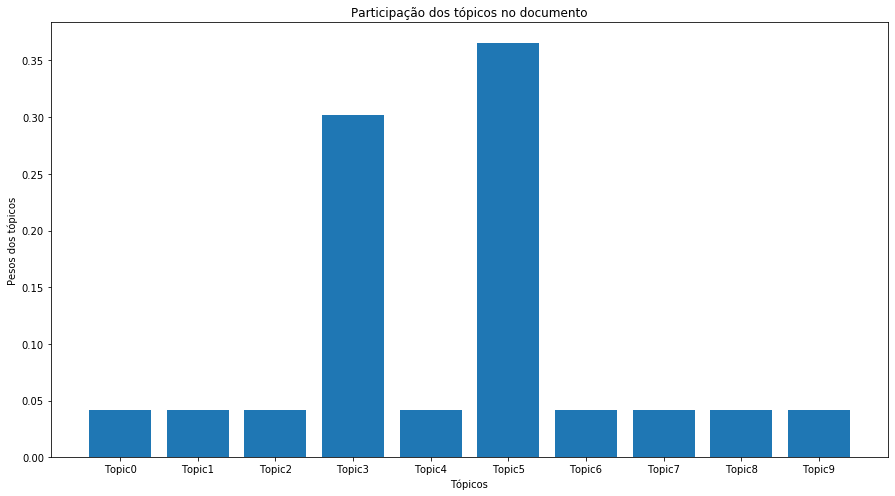

In [23]:
plt.figure(figsize=(15,8))
x = df_document_topic.columns[0:10].values
y = ps
plt.bar(x, y)
plt.ylabel('Pesos dos tópicos')
plt.xlabel('Tópicos')
plt.title('Participação dos tópicos no documento')
plt.show()

In [24]:
###Como o topico que o problema faz parte é o 5, irei procurar nesse topico soluções de realidade aumentada
df_document_topic = df_document_topic[df_document_topic['dominant_topic'] == 5]
ra =[word for word in df_document_topic.index.values if ('REALIDADE' in word) & ('AUMENTADA' in word)]
df_ra =  df_document_topic[df_document_topic.index.isin(ra)]
df_ra

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
NM_PROJETO,,,,,,,,,,,
"ARSTUDIO - INOVAÇÃO NA GERAÇÃO DE CONTEÚDO DIGITAL PARA TELEVISÃO, CINEMA E EDUCAÇÃO À DISTÂNCIA UTILIZANDO TÉCNICAS DE REALIDADE AUMENTADA.",0.03,0.03,0.03,0.03,0.03,0.70,0.03,0.03,0.03,0.03,5
SISTEMA MULTIMODAL PARA TREINAMENTO A DISTÂNCIA EM AMBIENTE VIRTUAL OU DE REALIDADE AUMENTADA DESTINADO AOS USUÁRIOS DE CADEIRAS DE RODAS MOTORIZADAS,0.03,0.03,0.03,0.03,0.03,0.37,0.37,0.03,0.03,0.03,5
CENA E INTERMEDIALIDADE: REALIDADE AUMENTADA E EFEITOS INTERMEDIAIS,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,5
"ARSTUDIO - INOVAÇÃO NA GERAÇÃO DE CONTEÚDO DIGITAL PARA TELEVISÃO, CINEMA E EDUCAÇÃO À DISTÂNCIA UTILIZANDO TÉCNICAS DE REALIDADE AUMENTADA",0.03,0.03,0.03,0.03,0.03,0.70,0.03,0.03,0.03,0.03,5
O MANUAL DO PROPRIETÁRIO DA EDIFICAÇÃO INCORPORANDO A REALIDADE AUMENTADA,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,5
ESTUDOS AVANÇADOS EM REALIDADE AUMENTADA,0.03,0.03,0.03,0.03,0.03,0.37,0.03,0.03,0.03,0.37,5
"HOLOGRAFICOS , SENSACOES E SENTIDOS: DESVELANDO EXPERIENCIAS ESTETICAS POR MEIO DE TECNOLOGIAS DE REALIDADE AUMENTADA NA CYBERFORMACAO COM PROFESSORES DE MATEMATICA",0.03,0.03,0.03,0.03,0.03,0.37,0.37,0.03,0.03,0.03,5
APLICAÇÕES DA CAPTURA DE MOVIMENTO E DA REALIDADE AUMENTADA,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,5


In [25]:
df_proj = df_ra.sort_values(by='Topic5', ascending=False) ##Os 3 primeiros são irrelevantes Não sao aplicaveis em saude
df_proj = df_proj[3:]

In [26]:
projetos = df_proj.index.values
projetos #todos os projetos que selecionamos

array(['O MANUAL DO PROPRIETÁRIO DA EDIFICAÇÃO INCORPORANDO A REALIDADE AUMENTADA',
       'APLICAÇÕES DA CAPTURA DE MOVIMENTO E DA REALIDADE AUMENTADA',
       'SISTEMA MULTIMODAL PARA TREINAMENTO A DISTÂNCIA EM AMBIENTE VIRTUAL OU DE REALIDADE AUMENTADA DESTINADO AOS USUÁRIOS DE CADEIRAS DE RODAS MOTORIZADAS',
       'ESTUDOS AVANÇADOS EM REALIDADE AUMENTADA',
       'HOLOGRAFICOS , SENSACOES E SENTIDOS: DESVELANDO EXPERIENCIAS ESTETICAS POR MEIO DE TECNOLOGIAS DE REALIDADE AUMENTADA NA CYBERFORMACAO COM PROFESSORES DE MATEMATICA'],
      dtype=object)

In [27]:
df_match = df
df_proj_cod = df_match[df['NM_PROJETO'].isin(projetos)]

cod_projs = df_proj_cod['ID_PROJETO']
cod_projs
df_proj_cod #adicionando o código do projeto

,ID_PROJETO,NM_PROJETO,NM_AREA_CONCENTRACAO,NM_LINHA_PESQUISA
28266,375659.0,SISTEMA MULTIMODAL PARA TREINAMENTO A DISTÂNCI...,ENGENHARIA BIOMÉDICA,ENGENHARIA DE REABILITAÇÃO E TECNOLOGIAS ASSIS...
189919,440648.0,O MANUAL DO PROPRIETÁRIO DA EDIFICAÇÃO INCORPO...,"ARQUITETURA, TECNOLOGIA E CIDADE",TECNOLOGIA EM ARQUITETURA E URBANISMO
200960,454894.0,ESTUDOS AVANÇADOS EM REALIDADE AUMENTADA,INOVAÇÃO TECNOLÓGICA,TECNOLOGIA DA INFORMAÇÃO E COMUNICAÇÃO
268003,482441.0,"HOLOGRAFICOS , SENSACOES E SENTIDOS: DESVELAND...",ENSINO DE MATEMÁTICA,3. TECNOLOGIAS DA INFORMAÇÃO E COMUNICAÇÃO NA ...
376479,399951.0,APLICAÇÕES DA CAPTURA DE MOVIMENTO E DA REALID...,ESTUDOS CULTURAIS,CULTURA E TECNOLOGIA


In [28]:
df_dis = pd.read_csv('projetos.csv', sep=';', encoding = 'latin1')
df_dis.columns.values

array(['AN_BASE', 'ID_ADD_FOTO_PROGRAMA', 'ID_ADD_FOTO_PROGRAMA_IES',
       'AN_INICIO_PROGRAMA', 'ID_ADD_CONTEXTO', 'ID_PROJETO',
       'IN_RESPONSAVEL_PROJETO', 'ID_ADD_MEMBRO_PROJETO', 'ID_PESSOA',
       'DS_TIPO_MEMBRO', 'ID_ADD_PARTICIPANTE_EXTERNO', 'ID_ADD_DISCENTE',
       'ID_ADD_DOCENTE', 'NM_MEMBRO_PROJETO',
       'NM_PAIS_NACIONALIDADE_MEMBRO', 'TP_SEXO_MEMBRO',
       'DS_CATEGORIA_MEMBRO_PROJETO', 'DT_INICIO_VINCULO',
       'DT_FIM_VINCULO'], dtype=object)

In [29]:
#fazendo o mapeamento pelo id do projeto para encontrar os responsáveis
df_dis = df_dis[['ID_PROJETO', 'NM_MEMBRO_PROJETO', 'DS_TIPO_MEMBRO']]
df_select = df_dis[(df_dis['ID_PROJETO'].isin(cod_projs)) & (df_dis['DS_TIPO_MEMBRO'] == 'DOCENTE')]
df_select.drop_duplicates(subset='ID_PROJETO', inplace=True)
df_select

/home/sergio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ID_PROJETO,NM_MEMBRO_PROJETO,DS_TIPO_MEMBRO
106857,454894,EZEQUIEL ROBERTO ZORZAL,DOCENTE
269868,482441,MAURICIO ROSA,DOCENTE
699157,440648,REGINA COELI RUSCHEL,DOCENTE
854736,399951,JOAO VICTOR BOECHAT GOMIDE,DOCENTE
856882,375659,ADRIANO ALVES PEREIRA,DOCENTE


In [52]:
#GRID SEARCH
#esse algoritmo foi rodado uma vez devido ao altissimo tempo de execução
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter = 10, learning_method='online', random_state=42)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(bag_of_words)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1, random_state=42,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                             

In [53]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(bag_of_words))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -1025376.6943697818
Model Perplexity:  4745.598539567499


In [56]:
lda_model = best_lda_model